In [1]:
import numpy as np
from astropy import units, constants
from astropy.units import def_unit

from scipy import stats
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('../rodd_style.mplstyle')

# Defining our 95% exclusion threshold
snr_target = stats.chi2.ppf(.9, df = 1)**.5

In [2]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html


from cycler import cycler

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = True 

In [3]:
# Mass-coupling relation
KSVZ = 1.92
DFSZ = 0.75

def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a

# Let's define our units

- Impedances – $\Omega$  
- Inductance – H
- Voltage - V
- Frequency – MHz  
- Temperature – mK
- Magnetic Field - Tesla

In [4]:
planck_h = constants.h.to(units.eV/units.MHz).value
boltzmann_k = constants.k_B.to(units.eV/units.mK).value

# Some useful unit conversions from GUTCalc
voltage_to_eV = 3.30227
henry_to_inveV = 4.03278e+12

# A/m^2 * GeV / T
external_current_units = 10.6049

In [5]:
rescale_factor = 1

In [6]:
1/external_current_units

0.09429603296589312

In [7]:
# Loading the data
# voltage_data = np.loadtxt('../Shielded_Solenoid/Port_Voltage_5_50.txt', skiprows = 5).T
# source_impedance_data = np.loadtxt('../Shielded_Solenoid/Source_Impedance_5_50.txt', skiprows = 5).T




# source_impedance_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_impedance.npy')
# voltage_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_voltage.npy')


res_folder='Shielded_Solenoid/josh_independent_check_shreya_geometry'
source_impedance_data = np.load(res_folder+'/source_impedance.npy')
voltage_data = np.load(res_folder+'/source_voltage.npy')

frequencies = 1e3*source_impedance_data[0] / rescale_factor
source_reactance = source_impedance_data[2] * rescale_factor# Sim was lossless.
source_voltage = rescale_factor**2 * np.abs(voltage_data[1]+1j*voltage_data[2]) # Don't care about phase



locs =np.where(frequencies<=np.inf)
frequencies = frequencies[locs]
source_reactance = source_reactance[locs]
source_voltage = source_voltage[locs]

# Defining the splines
get_source_voltage = CubicSpline(frequencies, source_voltage)
get_source_reactance = CubicSpline(frequencies, source_reactance)
get_source_reactance_derivative = get_source_reactance.derivative()

In [8]:
def get_Leff(freq):
    """
    Compute the effective inductance L_eff at a given frequency.
    This implements Eq. (6) from arXiv:2302.14084:
        L_eff(f) = [Z_s(f) + f * dZ_s/df] / (4π f)
    """
    
    # Compute numerator: freq * dZs/df + Zs, all in Ohms
    numerator = freq * get_source_reactance_derivative(freq)+ get_source_reactance(freq)
    denominator = 4 * np.pi * (1e6*freq)

    return (numerator / denominator)

(1e-18, 1e-10)

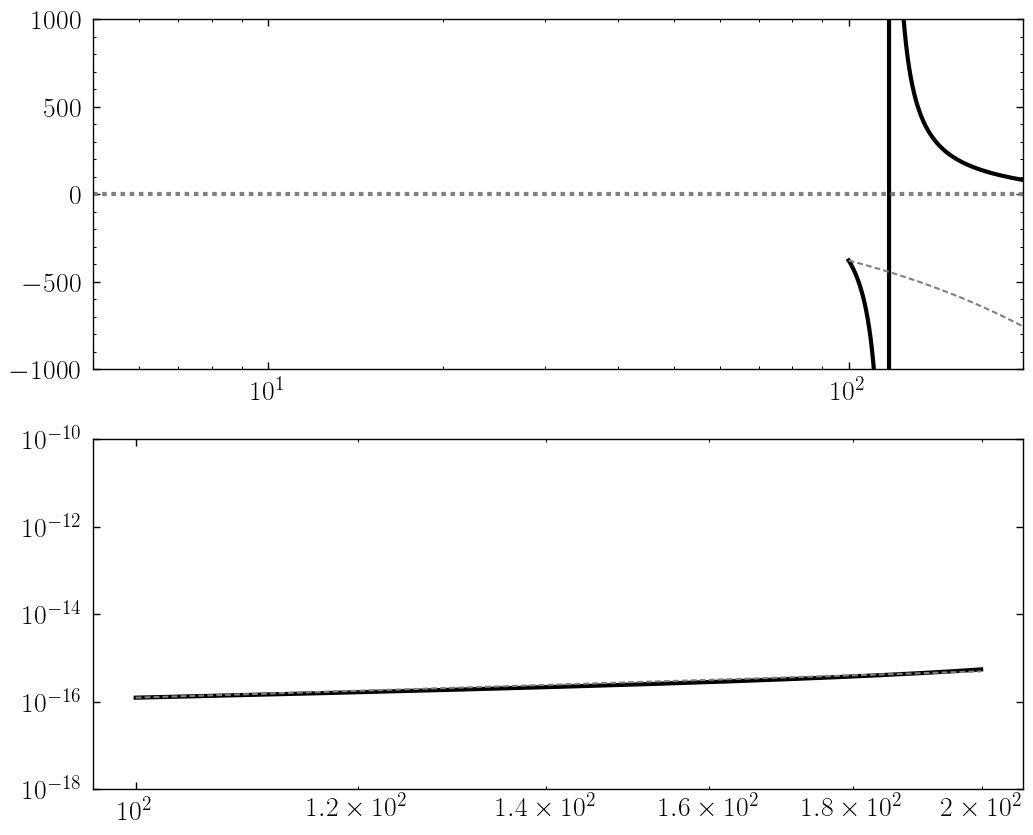

In [9]:
fig, axs = plt.subplots(nrows = 2, figsize = (12,10))

axs[0].plot(frequencies,  source_reactance,color = 'black', lw= 3)
axs[0].plot(frequencies,  source_reactance[0] * frequencies/ frequencies[0],color = 'grey', ls='--')
axs[0].set_ylim(-1e3, 1e3)
axs[0].set_xlim(5,200)

dfsz_coupling = g_x(DFSZ, 2*np.pi * 6.58212e-10 * frequencies)
axs[1].plot(frequencies, 10*source_voltage  * dfsz_coupling, color = 'black', lw =3)
axs[1].plot(frequencies, 10*source_voltage[0] * (frequencies/frequencies[0])*dfsz_coupling, color = 'grey', ls = '--')
axs[1].set_yscale('log')
axs[0].set_xlim(5,200)

axs[0].axhline(0, color= 'grey', lw = 3, ls = ':')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_ylim(1e-18,1e-10)

# Scan Rate Calculation

In [10]:
def get_GBar(nu_r, T, eta_A=10):
    
    # --- Compute thermal photon occupation number n_T ---
    exponent = (planck_h * nu_r) / (boltzmann_k * T)
    n_T = 1 / (np.exp(exponent) - 1)

    # --- Compute alpha_bar (Eq. 13) ---
    two_nT_plus_1 = 2 * n_T + 1
    alpha_bar = (2 * eta_A**2) / (two_nT_plus_1 + np.sqrt(two_nT_plus_1**2 + 8 * eta_A**2))

    # --- Compute Ḡ (Eq. 12) ---
    denom = (alpha_bar**2 + 2 * two_nT_plus_1 * alpha_bar + eta_A**2)**(3 / 2)
    GBar = alpha_bar / denom

    return GBar

In [11]:
def dnu_dt(nu_r, Q=2e5, T=10, C_ag = KSVZ, B = 5):

    ma_nat = constants.h.to('eV/MHz').value * nu_r # [eV]
    prefactor = 6.4e5*np.pi / snr_target**2 / 16 / ma_nat**4 # [1/eV^4]

    GBar = get_GBar(nu_r, T) # unitless
    Leff = get_Leff(nu_r)*henry_to_inveV # [1/eV]

    # The voltage was computed using an external current density with |J| = 1 A / m^2 so now
    # now we need to convert this to the appropriate current density for our axion scenario
    g_agg = g_x(C_ag, ma_nat) # GeV^(-1)
    voltage_rescaling = external_current_units * g_agg * B # A / m^2
    V = voltage_rescaling * get_source_voltage(nu_r) * voltage_to_eV # [eV]
    print(nu_r[0],prefactor[0], V[0], Leff[0], Q, GBar[0])
    
    # Now calculate scan rate
    scan_rate = prefactor * V**4 * Q * GBar  / Leff**2 # [eV^2]
    scan_rate /= constants.h.to('eV/MHz').value # [eV-Hz]
    scan_rate /= constants.h.to(units.eV * units.yr).value    
    
    return scan_rate

100.0 1.5877159498947013e+30 3.913528259341743e-15 -8706509.072739722 10000.0 0.002347236970104411
100.0 1.5877159498947013e+30 1.0018632343914861e-12 -8706509.072739722 10000.0 0.002347236970104411


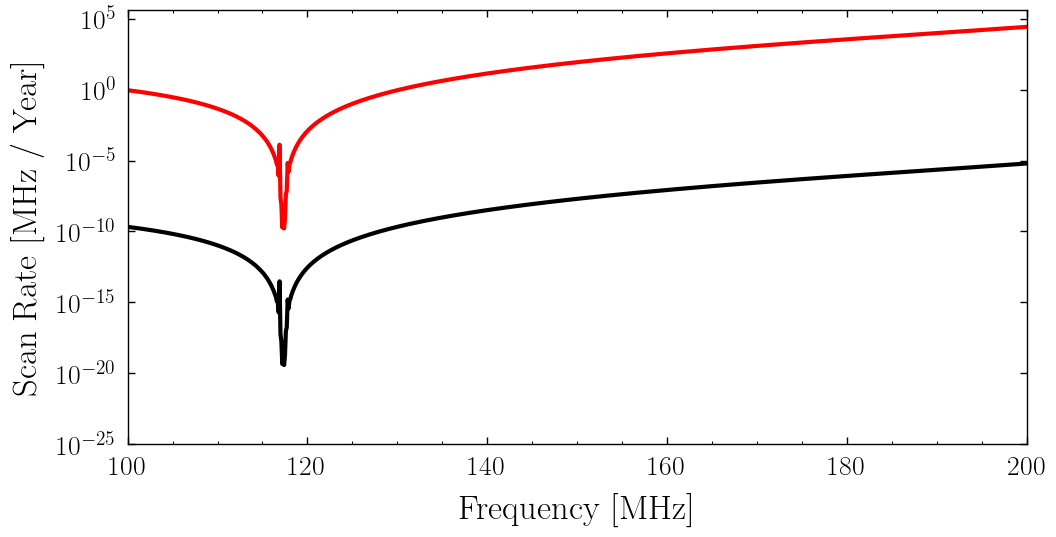

In [12]:
fig, axs = plt.subplots(figsize = (10, 5))

#match_x= frequencies[0]
#match_y = np.interp(match_x,frequencies, dnu_dt(frequencies, Q = 1e6, B = 15, C_ag = DFSZ))


plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = DFSZ), color = 'black', lw = 3)
plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = 100*KSVZ), color = 'red', lw = 3)
#plt.plot(frequencies, dnu_dt(frequencies, Q = 1e6, B = 10, C_ag = KSVZ), color = 'black', lw = 3,ls = '--')
#plt.xlim(frequencies[0], frequencies[-1])
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout()
#plt.axvspan(10, 58)
plt.ylim(1e-25, None)
plt.xlim(100,200)

#plt.ylim(1e-4, 1e2)
plt.xlabel('Frequency [MHz]')
plt.ylabel("Scan Rate [MHz / Year]")
plt.savefig('./WithWrongScaling.png')